<h1>MODELAGEM PREDITIVA DE CRIPTOATIVOS COM ARIMA</h1>
<p>Vinicius Barrozo Meireles</p>
<ul>
<li><b>Parte 2/5 - Análise e Exploração dos Dados</b></li>
<li><b>Parte 3/5 - Processamento dos Dados</b></li>
<li><b>Parte 4/5 - Criação dos Modelos de Machine Learning</b></li>
<li><b>Parte 5/5 - Apresentação dos Resultados</b></li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm
import random

import warnings
warnings.filterwarnings('ignore')

<h2>Parte 2/5 - Análise e Exploração dos Dados</h2>

In [2]:
tickers = pd.read_csv('tickers.csv', index_col=0)
print(tickers)

        Market       Provider    Color   Color2
Ticker                                         
BLX        BTC   Trading View  #ff9900  #cc6600
BTC-USD    BTC  Yahoo Finance  #ff9900  #cc6600
ETH-USD    ETH  Yahoo Finance  #666666  #333333
ETH-BTC    ETH            NaN  #666666  #333333
XRP-USD    XRP  Yahoo Finance  #006699  #003366
XRP-BTC    XRP            NaN  #006699  #003366


In [3]:
markets = pd.Series()

# Leitura do BLX da BNC via TradingView
markets['BLX'] = pd.read_csv('blx.csv', index_col=0, parse_dates=True).tz_localize(None)

# Leitura dos demais mercados via Yahoo Finance
for ticker, market in tickers.loc[tickers.Provider == 'Yahoo Finance'].Market.items():
    markets[ticker] = pd.read_csv(market.lower()+'.csv', index_col=0, parse_dates=True)

In [4]:
# Definição da série zerada auxiliar
zeroes = pd.Series().reindex(markets['BLX'].index).fillna(0)
ones = pd.Series().reindex(markets['BLX'].index).fillna(1)

In [5]:
markets['BLX']

,Open,High,Low,Close,Volume
Date,,,,,
2010-07-18,0.05941,0.08585,0.059410,0.085840,75.0100
2010-07-19,0.09090,0.09307,0.078905,0.080800,574.0000
2010-07-20,0.08181,0.08181,0.074260,0.074733,262.0000
2010-07-21,0.07425,0.07921,0.066340,0.079210,575.0000
2010-07-22,0.07921,0.08080,0.054460,0.054955,2160.0000
...,...,...,...,...,...
2020-11-20,17824.30458,18819.80864,17779.415440,18675.979020,47607.7697
2020-11-21,18683.87272,18964.50679,18413.087040,18695.304420,32175.4547
2020-11-22,18709.88521,18751.71274,17600.666690,18439.860460,40553.2810


In [6]:
markets['BTC-USD']

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834992,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084992,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2020-11-20,17817.083980,18773.226560,17765.794920,18621.314450,36992873939
2020-11-21,18621.316410,18936.621090,18444.359380,18642.232420,39650210707
2020-11-22,18642.232420,18688.968750,17671.384770,18370.001950,41280434225


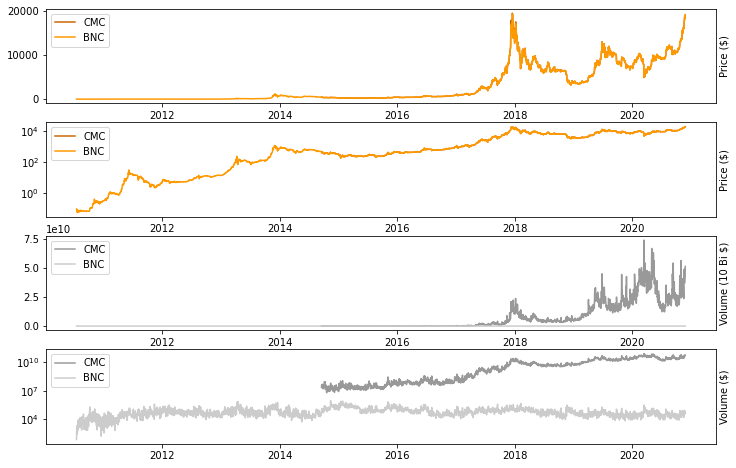

In [7]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.plot(markets['BTC-USD'].Close, c=tickers.Color2['BTC-USD'], label='CMC')
pp.plot(markets['BLX'].Close, c=tickers.Color['BLX'], label='BNC')
pp.ylabel('Price ($)')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.plot(markets['BTC-USD'].Close, c=tickers.Color2['BTC-USD'], label='CMC')
pp.plot(markets['BLX'].Close, c=tickers.Color['BLX'], label='BNC')
pp.ylabel('Price ($)')
pp.yscale('log')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.plot(markets['BTC-USD'].Volume, c='#999999', label='CMC')
pp.plot(markets['BLX'].Volume, c='#cccccc', label='BNC')
pp.ylabel('Volume (10 Bi $)')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['BTC-USD'].Volume, c='#999999', label='CMC')
pp.plot(markets['BLX'].Volume, c='#cccccc', label='BNC')
pp.ylabel('Volume ($)')
pp.yscale('log')
pp.legend(loc=2)

pp.show()

In [8]:
print(markets['BLX'].isnull().sum())

dindex = ['Count', 'Mean', 'S Deviation', 'Minimum', '25%', '50%', '75%', 'Maximum']
df = markets['BLX'].describe()
df.index = dindex
df.round(2)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


,Open,High,Low,Close,Volume
Count,3777.00,3777.00,3777.00,3777.00,3777.00
Mean,2839.95,2918.68,2753.61,2844.94,73463.57
S Deviation,4018.52,4135.76,3885.72,4026.85,76842.94
Minimum,0.05,0.06,0.01,0.05,75.01
25%,29.87,31.46,28.36,29.89,27678.69
50%,478.72,497.24,467.76,480.52,49299.76
75%,5828.12,6061.88,5689.77,5848.93,91190.71
Maximum,19326.51,19764.51,18728.19,19324.23,854474.79


In [9]:
print(markets['BTC-USD'].isnull().sum())

df = markets['BTC-USD'].describe()
df.index = dindex
df.round(2)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


,Open,High,Low,Close,Volume
Count,2261.00,2261.00,2261.00,2261.00,2.261000e+03
Mean,4657.94,4774.60,4536.89,4666.13,8.599178e+09
S Deviation,4356.61,4480.01,4223.02,4366.41,1.218860e+10
Minimum,176.90,211.73,171.51,178.10,5.914570e+06
25%,439.35,448.05,434.34,439.32,6.119410e+07
50%,3822.47,3904.90,3687.23,3836.74,2.716310e+09
75%,8232.38,8393.04,8031.22,8243.72,1.472210e+10
Maximum,19475.80,20089.00,18974.10,19497.40,7.415677e+10


In [10]:
markets['ETH-USD']

,Open,High,Low,Close,Volume
Date,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,164329
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100
...,...,...,...,...,...
2020-11-20,471.631470,513.610352,471.631470,509.744568,18629943296
2020-11-21,509.744598,550.227417,504.237762,549.486633,20757099183
2020-11-22,549.486633,579.372498,514.517212,558.068115,21967049601


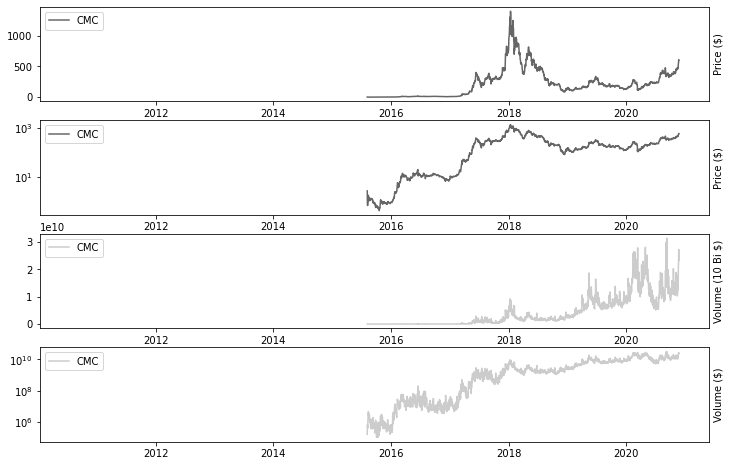

In [11]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Close, c=tickers.Color['ETH-USD'], label='CMC')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Close, c=tickers.Color['ETH-USD'], label='CMC')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (10 Bi $)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Volume, c='#cccccc', label='CMC')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Volume, c='#cccccc', label='CMC')
pp.legend(loc=2)

pp.show()

In [12]:
print(markets['ETH-USD'].isnull().sum())

df = markets['ETH-USD'].describe()
df.index = dindex
df.round(2)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


,Open,High,Low,Close,Volume
Count,1937.00,1937.00,1937.00,1937.00,1.937000e+03
Mean,215.64,223.17,207.36,215.90,4.258198e+09
S Deviation,227.29,237.06,215.83,227.30,5.633449e+09
Minimum,0.43,0.48,0.42,0.43,1.021280e+05
25%,12.44,12.80,11.95,12.43,2.433550e+07
50%,176.35,181.67,172.19,176.37,1.694300e+09
75%,297.60,306.74,289.31,297.47,7.129569e+09
Maximum,1397.48,1432.88,1290.60,1396.42,3.142113e+10


In [13]:
print('Price Correlation:', markets['ETH-USD'].Close.corr(markets['BTC-USD'].Close))
print('Volume Correlation:', markets['ETH-USD'].Volume.corr(markets['BTC-USD'].Volume))

Price Correlation: 0.7364686749531562
Volume Correlation: 0.9664253032258011


In [14]:
markets['XRP-USD']

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,0.005123,0.005803,0.005123,0.005399,1281960
2014-09-18,0.005398,0.005521,0.005091,0.005135,491147
2014-09-19,0.005134,0.005167,0.004873,0.004942,407109
2014-09-20,0.004942,0.004954,0.004736,0.004772,322621
2014-09-21,0.004768,0.004791,0.004540,0.004570,309571
...,...,...,...,...,...
2020-11-20,0.303766,0.329393,0.298203,0.328068,6283633941
2020-11-21,0.328068,0.463057,0.328068,0.458344,16206296041
2020-11-22,0.458344,0.491902,0.413256,0.443700,19097682286


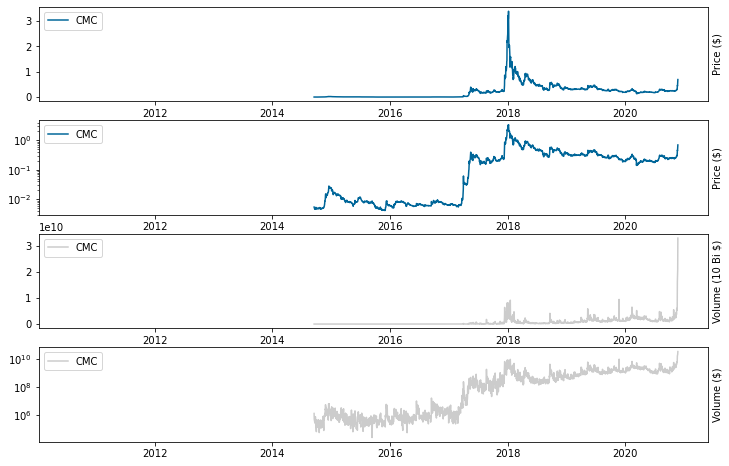

In [15]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Close, c=tickers.Color['XRP-USD'], label='CMC')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Close, c=tickers.Color['XRP-USD'], label='CMC')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (10 Bi $)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Volume, c='#cccccc', label='CMC')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Volume, c='#cccccc', label='CMC')
pp.legend(loc=2)

pp.show()

In [16]:
print(markets['XRP-USD'].isnull().sum())

df = markets['XRP-USD'].describe()
df.index = dindex
df.round(4)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


,Open,High,Low,Close,Volume
Count,2261.0000,2261.0000,2261.0000,2261.0000,2.261000e+03
Mean,0.2269,0.2373,0.2163,0.2272,7.181502e+08
S Deviation,0.3136,0.3395,0.2889,0.3137,1.402757e+09
Minimum,0.0041,0.0042,0.0040,0.0041,2.481800e+04
25%,0.0078,0.0079,0.0077,0.0078,8.602170e+05
50%,0.1980,0.2033,0.1931,0.1982,1.945420e+08
75%,0.3073,0.3139,0.2993,0.3073,1.113650e+09
Maximum,3.3636,3.8419,3.1173,3.3778,3.282619e+10


In [17]:
print('Price Correlation:', markets['XRP-USD'].Close.corr(markets['BTC-USD'].Close))
print('Volume Correlation:', markets['XRP-USD'].Volume.corr(markets['BTC-USD'].Volume))

Price Correlation: 0.6550963157379173
Volume Correlation: 0.6673870431062622


In [18]:
# Cálculo das diferenças absolutas e relativas entre as séries BLX (Brave New Coin) e BTC-USD (CoinMarketCap)
ard = pd.DataFrame()
ard['AClose'] = markets['BTC-USD'].Close - markets['BLX'].Close
ard['RClose'] = markets['BTC-USD'].Close / markets['BLX'].Close
ard['AVolume'] = markets['BTC-USD'].Volume - markets['BLX'].Volume
ard['RVolume'] = markets['BTC-USD'].Volume / markets['BLX'].Volume

In [19]:
ard.dropna(inplace=True)
ard

,AClose,RClose,AVolume,RVolume
Date,,,,
2014-09-17,1.470848,1.003227,2.100622e+07,4.163085e+02
2014-09-18,0.899951,1.002125,3.437237e+07,3.111481e+02
2014-09-19,0.663829,1.001684,3.779979e+07,3.162451e+02
2014-09-20,1.731999,1.004254,3.674704e+07,3.162523e+02
2014-09-21,0.597057,1.001499,2.649692e+07,3.195342e+02
...,...,...,...,...
2020-11-20,-54.664570,0.997073,3.699283e+10,7.770344e+05
2020-11-21,-53.072000,0.997161,3.965018e+10,1.232312e+06
2020-11-22,-69.858510,0.996212,4.128039e+10,1.017931e+06


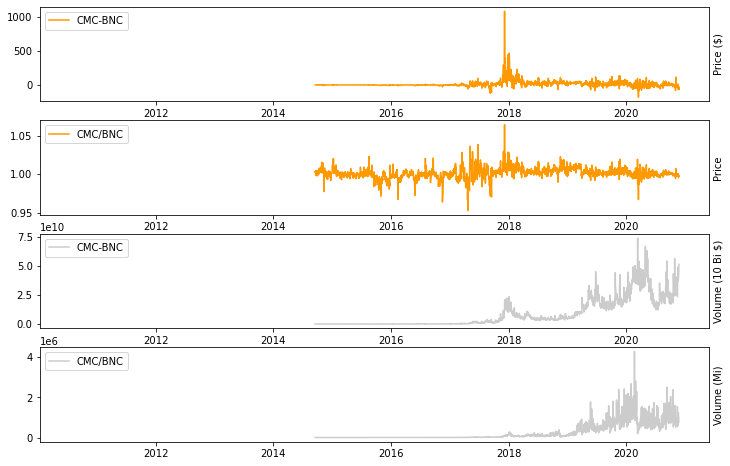

In [20]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.plot(zeroes, c='#ffffff')
pp.plot(ard.AClose, c=tickers.Color['BLX'], label='CMC-BNC')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price')
pp.plot(ones, c='#ffffff')
pp.plot(ard.RClose, c=tickers.Color['BLX'], label='CMC/BNC')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (10 Bi $)')
#pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(ard.AVolume, c='#cccccc', label='CMC-BNC')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume (Mi)')
#pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(ard.RVolume, c='#cccccc', label='CMC/BNC')
pp.legend(loc=2)

pp.show()

In [21]:
df = ard.describe()
df.index = dindex
df.round(4)

,AClose,RClose,AVolume,RVolume
Count,2261.0000,2261.0000,2.261000e+03,2.261000e+03
Mean,14.1732,1.0013,8.599092e+09,2.590128e+05
S Deviation,50.2000,0.0072,1.218863e+10,4.383232e+05
Minimum,-178.6652,0.9526,5.828033e+06,4.298230e+01
25%,-1.6064,0.9983,6.116839e+07,8.191150e+02
50%,1.0549,1.0010,2.716049e+09,2.852742e+04
75%,21.9042,1.0044,1.472206e+10,3.728335e+05
Maximum,1080.8673,1.0643,7.415647e+10,4.276324e+06


<h2>Parte 3/5 - Processamento dos Dados</h2>

<strong>3.1 - Estimação dos Preços e Volumes</strong>

In [22]:
# Estimação dos preços de fechamento e do volume do ETH-USD com base nas proporções entre os dados do BLX e do BTC-USD
markets['ETH-USD']['EClose'] = markets['ETH-USD'].Close / ard.RClose
markets['ETH-USD']['RVolume'] = markets['ETH-USD'].Volume / markets['BTC-USD'].Volume
markets['ETH-USD']['EVolume'] = markets['BLX'].Volume * markets['ETH-USD'].RVolume

# Estimação dos preços de fechamento e do volume do XRP-USD com base nas proporções entre os dados do BLX e do BTC-USD
markets['XRP-USD']['EClose'] = markets['XRP-USD'].Close / ard.RClose
markets['XRP-USD']['RVolume'] = markets['XRP-USD'].Volume / markets['BTC-USD'].Volume
markets['XRP-USD']['EVolume'] = markets['BLX'].Volume * markets['XRP-USD'].RVolume

In [23]:
markets['ETH-USD'].dropna(inplace=True)
markets['ETH-USD']

,Open,High,Low,Close,Volume,EClose,RVolume,EVolume
Date,,,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,164329,2.779800,0.003868,212.387680
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188,0.750507,0.011518,1119.123697
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,0.701107,0.022370,1469.615232
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,0.705230,0.019318,1133.285098
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100,1.071144,0.057526,3763.824386
...,...,...,...,...,...,...,...,...
2020-11-20,471.631470,513.610352,471.631470,509.744568,18629943296,511.240970,0.503609,23975.700061
2020-11-21,509.744598,550.227417,504.237762,549.486633,20757099183,551.050950,0.523505,16844.024094
2020-11-22,549.486633,579.372498,514.517212,558.068115,21967049601,560.190369,0.532142,21580.100886


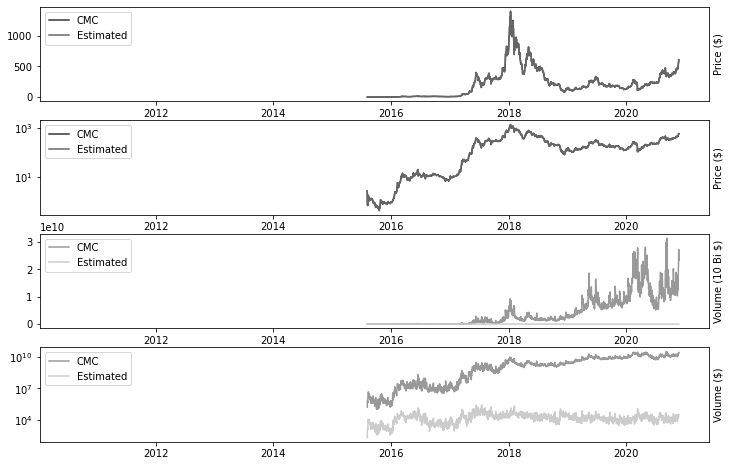

In [24]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Close, c=tickers.Color2['ETH-USD'], label='CMC')
pp.plot(markets['ETH-USD'].EClose, c=tickers.Color['ETH-USD'], label='Estimated')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Close, c=tickers.Color2['ETH-USD'], label='CMC')
pp.plot(markets['ETH-USD'].EClose, c=tickers.Color['ETH-USD'], label='Estimated')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (10 Bi $)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Volume, c='#999999', label='CMC')
pp.plot(markets['ETH-USD'].EVolume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-USD'].Volume, c='#999999', label='CMC')
pp.plot(markets['ETH-USD'].EVolume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.show()

In [25]:
markets['XRP-USD'].dropna(inplace=True)
markets['XRP-USD']

,Open,High,Low,Close,Volume,EClose,RVolume,EVolume
Date,,,,,,,,
2014-09-17,0.005123,0.005803,0.005123,0.005399,1281960,0.005381,0.060881,3079.350983
2014-09-18,0.005398,0.005521,0.005091,0.005135,491147,0.005125,0.014243,1578.499225
2014-09-19,0.005134,0.005167,0.004873,0.004942,407109,0.004934,0.010736,1287.321012
2014-09-20,0.004942,0.004954,0.004736,0.004772,322621,0.004751,0.008752,1020.138078
2014-09-21,0.004768,0.004791,0.004540,0.004570,309571,0.004563,0.011647,968.819510
...,...,...,...,...,...,...,...,...
2020-11-20,0.303766,0.329393,0.298203,0.328068,6283633941,0.329031,0.169861,8086.687129
2020-11-21,0.328068,0.463057,0.328068,0.458344,16206296041,0.459649,0.408732,13151.126686
2020-11-22,0.458344,0.491902,0.413256,0.443700,19097682286,0.445388,0.462633,18761.277364


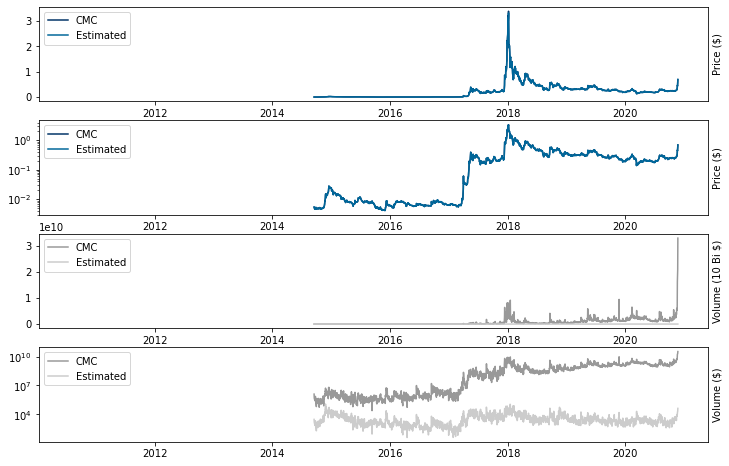

In [26]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Close, c=tickers.Color2['XRP-USD'], label='CMC')
pp.plot(markets['XRP-USD'].EClose, c=tickers.Color['XRP-USD'], label='Estimated')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Close, c=tickers.Color2['XRP-USD'], label='CMC')
pp.plot(markets['XRP-USD'].EClose, c=tickers.Color['XRP-USD'], label='Estimated')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (10 Bi $)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Volume, c='#999999', label='CMC')
pp.plot(markets['XRP-USD'].EVolume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume ($)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-USD'].Volume, c='#999999', label='CMC')
pp.plot(markets['XRP-USD'].EVolume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.show()

<strong>3.2 - Denominação das Séries</strong>

In [27]:
# Cálculo da série ETH denominada em BTC
markets['ETH-BTC'] = pd.DataFrame()
markets['ETH-BTC']['Close'] = markets['ETH-USD'].EClose / markets['BLX'].Close
markets['ETH-BTC']['Volume'] = markets['ETH-USD'].EVolume / markets['BLX'].Close

# Cálculo da série XRP denominada em BTC
markets['XRP-BTC'] = pd.DataFrame()
markets['XRP-BTC']['Close'] = markets['XRP-USD'].EClose / markets['BLX'].Close
markets['XRP-BTC']['Volume'] = markets['XRP-USD'].EVolume / markets['BLX'].Close

In [28]:
markets['ETH-BTC'].dropna(inplace=True)
markets['ETH-BTC']

,Close,Volume
Date,,
2015-08-07,0.009915,0.757555
2015-08-08,0.002886,4.303977
2015-08-09,0.002648,5.550226
2015-08-10,0.002679,4.304671
2015-08-11,0.003949,13.877509
...,...,...
2020-11-20,0.027374,1.283772
2020-11-21,0.029475,0.900976
2020-11-22,0.030379,1.170296


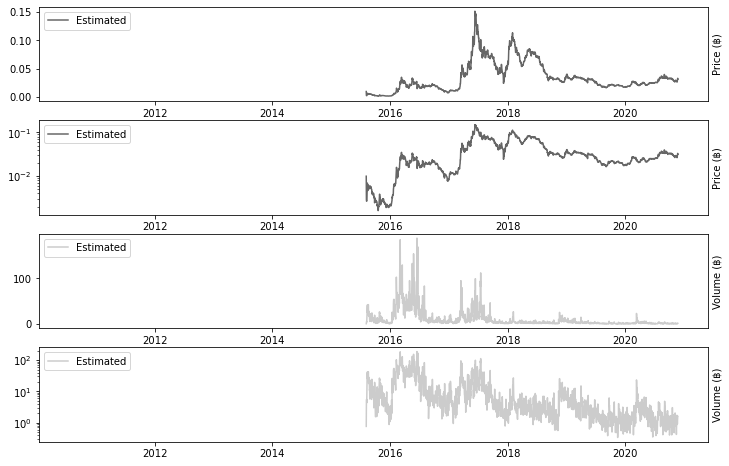

In [29]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price (฿)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-BTC'].Close, c=tickers.Color['ETH-BTC'], label='Estimated')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price (฿)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-BTC'].Close, c=tickers.Color['ETH-BTC'], label='Estimated')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (฿)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-BTC'].Volume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume (฿)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['ETH-BTC'].Volume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.show()

In [30]:
df = markets['ETH-BTC'].describe()
df.index = dindex
df.round(4)

,Close,Volume
Count,1937.0000,1937.0000
Mean,0.0346,10.6526
S Deviation,0.0257,19.3402
Minimum,0.0016,0.3342
25%,0.0190,1.7157
50%,0.0273,3.4555
75%,0.0415,9.1009
Maximum,0.1510,188.4803


In [31]:
markets['XRP-BTC'].dropna(inplace=True)
markets['XRP-BTC']

,Close,Volume
Date,,
2014-09-17,0.000012,6.754990
2014-09-18,0.000012,3.726918
2014-09-19,0.000013,3.266217
2014-09-20,0.000012,2.505423
2014-09-21,0.000011,2.432851
...,...,...
2020-11-20,0.000018,0.432999
2020-11-21,0.000025,0.703445
2020-11-22,0.000024,1.017431


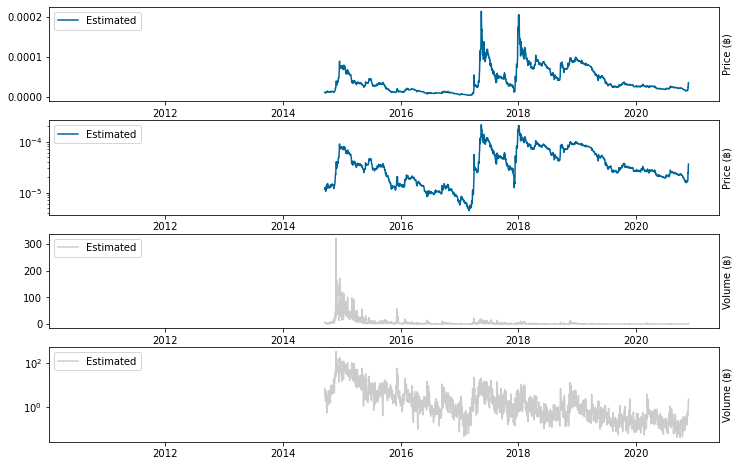

In [32]:
pp.figure(figsize=(12, 8))

pp.subplot(411).yaxis.set_label_position('right')
pp.ylabel('Price (฿)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-BTC'].Close, c=tickers.Color['XRP-BTC'], label='Estimated')
pp.legend(loc=2)

pp.subplot(412).yaxis.set_label_position('right')
pp.ylabel('Price (฿)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-BTC'].Close, c=tickers.Color['XRP-BTC'], label='Estimated')
pp.legend(loc=2)

pp.subplot(413).yaxis.set_label_position('right')
pp.ylabel('Volume (฿)')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-BTC'].Volume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.subplot(414).yaxis.set_label_position('right')
pp.ylabel('Volume (฿)')
pp.yscale('log')
pp.plot(zeroes, c='#ffffff')
pp.plot(markets['XRP-BTC'].Volume, c='#cccccc', label='Estimated')
pp.legend(loc=2)

pp.show()

In [33]:
df = markets['XRP-BTC'].describe()
df.index = dindex
df.round(6)

,Close,Volume
Count,2261.000000,2261.000000
Mean,0.000042,5.212628
S Deviation,0.000032,15.565541
Minimum,0.000004,0.039722
25%,0.000018,0.324288
50%,0.000030,0.908430
75%,0.000061,3.145585
Maximum,0.000214,321.555489


In [34]:
markets['BLX'].dropna(inplace=True)
markets['BLX']

,Open,High,Low,Close,Volume
Date,,,,,
2010-07-18,0.05941,0.08585,0.059410,0.085840,75.0100
2010-07-19,0.09090,0.09307,0.078905,0.080800,574.0000
2010-07-20,0.08181,0.08181,0.074260,0.074733,262.0000
2010-07-21,0.07425,0.07921,0.066340,0.079210,575.0000
2010-07-22,0.07921,0.08080,0.054460,0.054955,2160.0000
...,...,...,...,...,...
2020-11-20,17824.30458,18819.80864,17779.415440,18675.979020,47607.7697
2020-11-21,18683.87272,18964.50679,18413.087040,18695.304420,32175.4547
2020-11-22,18709.88521,18751.71274,17600.666690,18439.860460,40553.2810


<h2>Parte 4/5 - Criação dos Modelos de Machine Learning</h2>

<strong>4.1 - Definição das Séries de Treinamento e Validação</strong>

In [35]:
# Definição dos termos de fim e início das séries de treinamento e validação, respectivamente
tlst = '2020-06-30'
vfst = '2020-07-01'

<h4>4.2 - MODELO DE MÉDIA PONDERADA MÓVEL (VWAP)</h4>

<strong>4.2.1 - Previsão</strong>

In [36]:
%%time

# Definição do período, em dias, para o cálculo da média ponderada móvel
vwperiod = 7

# Cálculo dos valores das médias ponderadas móveis
for mindex, market in markets.items():
    if mindex == 'BTC-USD':
        continue
    market['VWAP'] = pd.Series()
    for cindex, close in market.Close[vfst:].items():
        i = market.Close.index.get_loc(cindex)
        vwnum, vwden = 0, 0
        for x in range(1, vwperiod):
            if mindex == ('ETH-USD' or 'XRP-USD'):
                vwnum += market.EClose[i-x] * market.EVolume[i-x]
                vwden += market.EVolume[i-x]
            else:
                vwnum += market.Close[i-x] * market.Volume[i-x]
                vwden += market.Volume[i-x]
        vwap = vwnum / vwden
        market['VWAP'][cindex] = vwap

Wall time: 369 ms


<h4>4.3 - MODELO DE CAMINHADA ALEATÓRIA (RANDOM WALK)</h4>

<strong>4.3.1 - Ajuste do Modelo de Caminhada Aleatória</strong>

In [37]:
%%time

# Cálculo dos valores relativos das séries (Close e Volume)
for mindex, market in markets.items():
    if mindex == 'BTC-USD':
        continue
    if mindex == ('ETH-USD' or 'XRP-USD'):
        market['RClose'] = market.EClose / market.EClose.shift()
    else:
        market['RClose'] = market.Close / market.Close.shift()

Wall time: 3.99 ms


In [38]:
#Eliminação dos outliers, abaixo e acima do 1º e do 99º percentil, respectivamente
for mindex, market in markets.items():
    if mindex == 'BTC-USD':
        continue
    mean = np.mean(market.RClose.fillna(1))
    min = np.percentile(market.RClose.fillna(1), 1)
    max = np.percentile(market.RClose.fillna(1), 99)
    market.RClose = market.RClose.mask(market.RClose < min, mean)
    market.RClose = market.RClose.mask(market.RClose > max, mean)

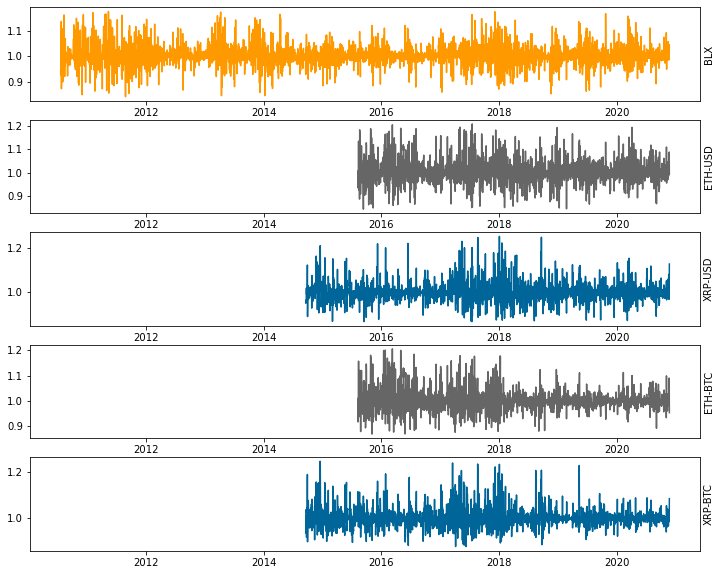

In [39]:
pp.figure(figsize=(12, 10))

pp.subplot(511).yaxis.set_label_position('right')
pp.ylabel('BLX')
pp.plot(markets['BLX'].RClose, c=tickers.Color['BLX'])

pp.subplot(512).yaxis.set_label_position('right')
pp.ylabel('ETH-USD')
pp.plot(ones, c='#ffffff')
pp.plot(markets['ETH-USD'].RClose, c=tickers.Color['ETH-USD'])

pp.subplot(513).yaxis.set_label_position('right')
pp.ylabel('XRP-USD')
pp.plot(ones, c='#ffffff')
pp.plot(markets['XRP-USD'].RClose, c=tickers.Color['XRP-USD'])

pp.subplot(514).yaxis.set_label_position('right')
pp.ylabel('ETH-BTC')
pp.plot(ones, c='#ffffff')
pp.plot(markets['ETH-BTC'].RClose, c=tickers.Color['ETH-BTC'])

pp.subplot(515).yaxis.set_label_position('right')
pp.ylabel('XRP-BTC')
pp.plot(ones, c='#ffffff')
pp.plot(markets['XRP-BTC'].RClose, c=tickers.Color['XRP-BTC'])

pp.show()

<strong>4.3.2 - Previsão</strong>

In [40]:
%%time

# Definição do período, em dias, para os valores possíveis das caminhadas aleatórias
rwperiod = 30

# Cálculo dos valores das caminhadas aleatórias
for mindex, market in markets.items():
    if mindex == 'BTC-USD':
        continue
    market['RWalk'] = pd.Series()
    for cindex, close in market.Close[vfst:].items():
        i = market.Close.index.get_loc(cindex)
        # Escolha aleatória do RCLOSE (evolução) de um dos RWPERIOD (30) períodos anteriores
        x = random.randint(1, rwperiod)
        if mindex == ('ETH-USD' or 'XRP-USD'):
            market['RWalk'][cindex] = market.EClose[i-1] * market.RClose[i-x]
        else:
            market['RWalk'][cindex] = market.Close[i-1] * market.RClose[i-x]

Wall time: 116 ms


<h4>4.4 - MODELO AUTORREGRESSIVO INTEGRADO DE MÉDIA MÓVEL (ARIMA)</h4>

<strong>4.4.1 - Transformação Box-Cox das Séries</strong>

In [41]:
lambdas = pd.DataFrame(index = ['BLX', 'ETH-USD', 'XRP-USD', 'ETH-BTC', 'XRP-BTC'])
lambdas['Close'] = pd.Series()
lambdas['Volume'] = pd.Series()

# Transformação Box-Cox das séries BLX, ETH-BTC e XRP-BTC (Close e Volume)
for market in ['BLX', 'ETH-BTC', 'XRP-BTC']:
    markets[market]['BClose'], lambdas.Close[market] = boxcox(markets[market].Close)
    markets[market]['BVolume'], lambdas.Volume[market] = boxcox(markets[market].Volume)

# Transformação Box-Cox das séries ETH-USD e XRP-USD (EClose e EVolume)
for market in ['ETH-USD', 'XRP-USD']:
    markets[market]['BClose'], lambdas.Close[market] = boxcox(markets[market].EClose)
    markets[market]['BVolume'], lambdas.Volume[market] = boxcox(markets[market].EVolume)

lambdas

,Close,Volume
BLX,0.135147,0.167772
ETH-USD,0.298481,0.172930
XRP-USD,0.109961,-0.025779
ETH-BTC,0.338808,-0.220649
XRP-BTC,0.060158,-0.159042


<strong>4.4.2 - Ajuste do Modelo ARIMA</strong>

In [42]:
%%time

arima = pd.Series()

# Ajuste automático dos modelos ARIMA por meio do método auto_arima()
for index, lbd in lambdas.Close.items():
    arima[index] = pm.auto_arima(markets[index].BClose[:tlst], seasonal=False)
    print(index, arima[index].order)

BLX (0, 1, 0)
ETH-USD (0, 1, 0)
XRP-USD (2, 1, 1)
ETH-BTC (1, 1, 0)
XRP-BTC (1, 1, 1)
Wall time: 24.3 s


<strong>4.4.3 - Análise dos Resíduos</strong>

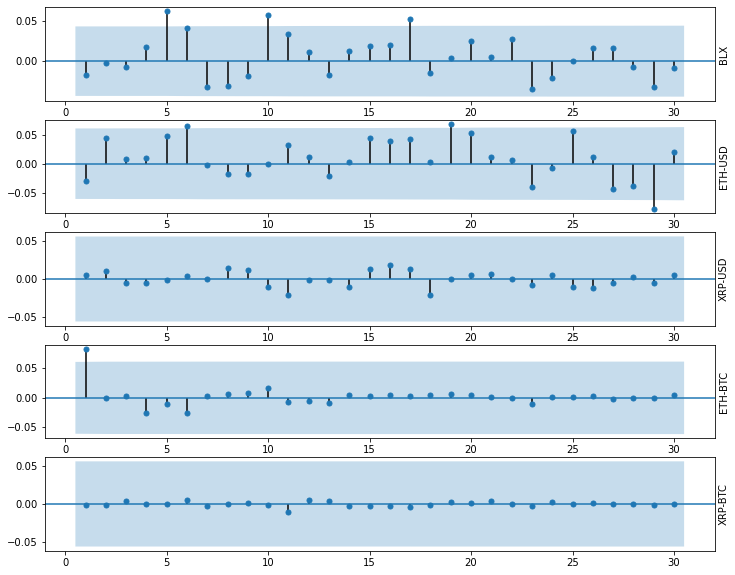

In [43]:
fig, ax = pp.subplots(5)
fig.set_size_inches(12, 10)

pm.plot_acf(arima['BLX'].resid(), ax=ax[0], lags=30, alpha=.01, title='', zero=False, show=False)
ax[0].set_ylabel('BLX')
ax[0].yaxis.set_label_position('right')

pm.plot_acf(arima['ETH-USD'].resid(), ax=ax[1], lags=30, alpha=.01, title='', zero=False, show=False)
ax[1].set_ylabel('ETH-USD')
ax[1].yaxis.set_label_position('right')

pm.plot_acf(arima['XRP-USD'].resid(), ax=ax[2], lags=30, alpha=.01, title='', zero=False, show=False)
ax[2].set_ylabel('XRP-USD')
ax[2].yaxis.set_label_position('right')

pm.plot_acf(arima['ETH-BTC'].resid(), ax=ax[3], lags=30, alpha=.01, title='', zero=False, show=False)
ax[3].set_ylabel('ETH-BTC')
ax[3].yaxis.set_label_position('right')

pm.plot_acf(arima['XRP-BTC'].resid(), ax=ax[4], lags=30, alpha=.01, title='', zero=False, show=False)
ax[4].set_ylabel('XRP-BTC')
ax[4].yaxis.set_label_position('right')

fig.show()

<strong>4.4.4 - Previsão</strong>

In [44]:
%%time

# Geração dos valores de previsão com atualização do modelo a cada etapa para simular a passagem dos dias
for mindex in lambdas.index:
    markets[mindex]['BPrediction'] = pd.Series()
    for cindex, close in markets[mindex].BClose[vfst:].items():
        markets[mindex]['BPrediction'].loc[cindex] = arima[mindex].predict(1)[0]
        arima[mindex].update(close)
    markets[mindex]['Prediction'] = inv_boxcox(markets[mindex].BPrediction, lambdas.Close[mindex])

Wall time: 2min 42s


<h2>Parte 5/5 - Apresentação dos Resultados</h2>

In [45]:
# Definição do método para cálculo do mean squared error
def mse(v, p):
    return np.mean((p - v)**2)

# Definição do método para cálculo do symmetric mean absolute percentage error
def smape(v, p):
    return np.mean((np.abs(p - v) * 200 / (np.abs(p) + np.abs(v))))

evaluation = pd.Series()
em = ('MSE', 'SMAPE')
ei = ('VWAP', 'RW', 'Last', 'ARIMA')

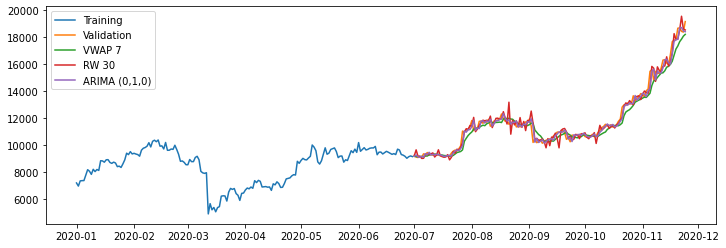

In [46]:
pp.figure(figsize=(12, 4))
pp.plot(markets['BLX'].Close['2020-01-01':tlst], label='Training')
pp.plot(markets['BLX'].Close[vfst:], label='Validation')
pp.plot(markets['BLX'].VWAP, label='VWAP ' + str(vwperiod))
pp.plot(markets['BLX'].RWalk[vfst:], label='RW ' + str(rwperiod))
pp.plot(markets['BLX'].Prediction, label='ARIMA (' + ','.join(map(str, arima['BLX'].order)) + ')')
pp.legend(loc=2)
pp.show()

In [47]:
market = 'BLX'

evaluation[market] = pd.DataFrame(columns=em, index=ei)

evaluation[market].MSE.VWAP = mse(markets[market].VWAP, markets[market].Close[vfst:])
evaluation[market].SMAPE.VWAP = smape(markets[market].VWAP, markets[market].Close[vfst:])

evaluation[market].MSE.RW = mse(markets[market].RWalk, markets[market].Close[vfst:])
evaluation[market].SMAPE.RW = smape(markets[market].RWalk, markets[market].Close[vfst:])

evaluation[market].MSE.Last = mse(markets[market].Close[vfst:].shift(-1), markets[market].Close[vfst:])
evaluation[market].SMAPE.Last = smape(markets[market].Close[vfst:].shift(-1), markets[market].Close[vfst:])

evaluation[market].MSE.ARIMA = mse(markets[market].Prediction, markets[market].Close[vfst:])
evaluation[market].SMAPE.ARIMA = smape(markets[market].Prediction, markets[market].Close[vfst:])

evaluation[market]

,MSE,SMAPE
VWAP,220514,2.6872
RW,176365,2.41885
Last,105171,1.7611
ARIMA,101992,1.72482


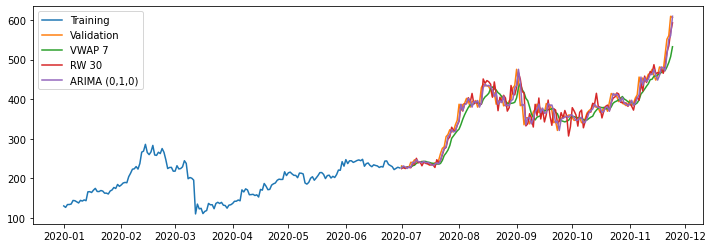

In [48]:
pp.figure(figsize=(12, 4))
pp.plot(markets['ETH-USD'].EClose['2020-01-01':tlst], label='Training')
pp.plot(markets['ETH-USD'].EClose[vfst:], label='Validation')
pp.plot(markets['ETH-USD'].VWAP, label='VWAP ' + str(vwperiod))
pp.plot(markets['ETH-USD'].RWalk[vfst:], label='RW ' + str(rwperiod))
pp.plot(markets['ETH-USD'].Prediction, label='ARIMA (' + ','.join(map(str, arima['ETH-USD'].order)) + ')')
pp.legend(loc=2)
pp.show()

In [49]:
market = 'ETH-USD'

evaluation[market] = pd.DataFrame(columns=em, index=ei)

evaluation[market].MSE.VWAP = mse(markets[market].VWAP, markets[market].EClose[vfst:])
evaluation[market].SMAPE.VWAP = smape(markets[market].VWAP, markets[market].EClose[vfst:])

evaluation[market].MSE.RW = mse(markets[market].RWalk, markets[market].EClose[vfst:])
evaluation[market].SMAPE.RW = smape(markets[market].RWalk, markets[market].EClose[vfst:])

evaluation[market].MSE.Last = mse(markets[market].EClose[vfst:].shift(-1), markets[market].EClose[vfst:])
evaluation[market].SMAPE.Last = smape(markets[market].EClose[vfst:].shift(-1), markets[market].EClose[vfst:])

evaluation[market].MSE.ARIMA = mse(markets[market].Prediction, markets[market].EClose[vfst:])
evaluation[market].SMAPE.ARIMA = smape(markets[market].Prediction, markets[market].EClose[vfst:])

evaluation[market]

,MSE,SMAPE
VWAP,688.942,4.87604
RW,436.324,4.21753
Last,256.112,2.98168
ARIMA,254.542,2.97636


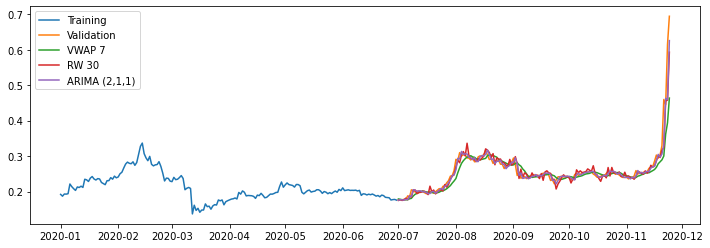

In [50]:
pp.figure(figsize=(12, 4))
pp.plot(markets['XRP-USD'].EClose['2020-01-01':tlst], label='Training')
pp.plot(markets['XRP-USD'].EClose[vfst:], label='Validation')
pp.plot(markets['XRP-USD'].VWAP, label='VWAP ' + str(vwperiod))
pp.plot(markets['XRP-USD'].RWalk[vfst:], label='RW ' + str(rwperiod))
pp.plot(markets['XRP-USD'].Prediction, label='ARIMA (' + ','.join(map(str, arima['XRP-USD'].order)) + ')')
pp.legend(loc=2)
pp.show()

In [51]:
market = 'XRP-USD'

evaluation[market] = pd.DataFrame(columns=em, index=ei)

evaluation[market].MSE.VWAP = mse(markets[market].VWAP, markets[market].EClose[vfst:])
evaluation[market].SMAPE.VWAP = smape(markets[market].VWAP, markets[market].EClose[vfst:])

evaluation[market].MSE.RW = mse(markets[market].RWalk, markets[market].EClose[vfst:])
evaluation[market].SMAPE.RW = smape(markets[market].RWalk, markets[market].EClose[vfst:])

evaluation[market].MSE.Last = mse(markets[market].EClose[vfst:].shift(-1), markets[market].EClose[vfst:])
evaluation[market].SMAPE.Last = smape(markets[market].EClose[vfst:].shift(-1), markets[market].EClose[vfst:])

evaluation[market].MSE.ARIMA = mse(markets[market].Prediction, markets[market].EClose[vfst:])
evaluation[market].SMAPE.ARIMA = smape(markets[market].Prediction, markets[market].EClose[vfst:])

evaluation[market]

,MSE,SMAPE
VWAP,0.00109302,4.75702
RW,0.000477602,3.63757
Last,0.000424772,2.76619
ARIMA,0.00037461,2.7011


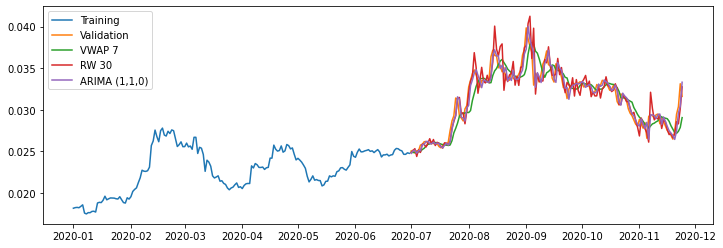

In [52]:
pp.figure(figsize=(12, 4))
pp.plot(markets['ETH-BTC'].Close['2020-01-01':tlst], label='Training')
pp.plot(markets['ETH-BTC'].Close[vfst:], label='Validation')
pp.plot(markets['ETH-BTC'].VWAP, label='VWAP ' + str(vwperiod))
pp.plot(markets['ETH-BTC'].RWalk[vfst:], label='RW ' + str(rwperiod))
pp.plot(markets['ETH-BTC'].Prediction, label='ARIMA (' + ','.join(map(str, arima['ETH-BTC'].order)) + ')')
pp.legend(loc=2)
pp.show()

In [53]:
market = 'ETH-BTC'

evaluation[market] = pd.DataFrame(columns=em, index=ei)

evaluation[market].MSE.VWAP = mse(markets[market].VWAP, markets[market].Close[vfst:])
evaluation[market].SMAPE.VWAP = smape(markets[market].VWAP, markets[market].Close[vfst:])

evaluation[market].MSE.RW = mse(markets[market].RWalk, markets[market].Close[vfst:])
evaluation[market].SMAPE.RW = smape(markets[market].RWalk, markets[market].Close[vfst:])

evaluation[market].MSE.Last = mse(markets[market].Close[vfst:].shift(-1), markets[market].Close[vfst:])
evaluation[market].SMAPE.Last = smape(markets[market].Close[vfst:].shift(-1), markets[market].Close[vfst:])

evaluation[market].MSE.ARIMA = mse(markets[market].Prediction, markets[market].Close[vfst:])
evaluation[market].SMAPE.ARIMA = smape(markets[market].Prediction, markets[market].Close[vfst:])

evaluation[market]

,MSE,SMAPE
VWAP,2.28143e-06,3.37593
RW,1.70665e-06,2.81482
Last,9.12295e-07,2.1252
ARIMA,9.07086e-07,2.10463


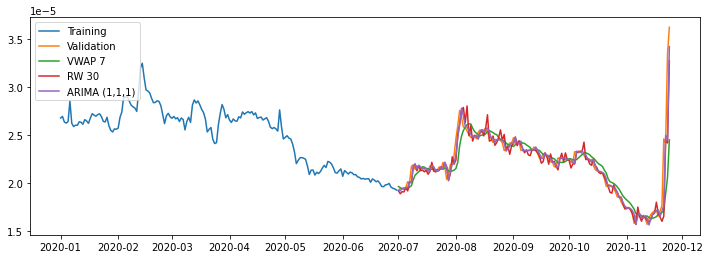

In [54]:
pp.figure(figsize=(12, 4))
pp.plot(markets['XRP-BTC'].Close['2020-01-01':tlst], label='Training')
pp.plot(markets['XRP-BTC'].Close[vfst:], label='Validation')
pp.plot(markets['XRP-BTC'].VWAP, label='VWAP ' + str(vwperiod))
pp.plot(markets['XRP-BTC'].RWalk[vfst:], label='RW ' + str(rwperiod))
pp.plot(markets['XRP-BTC'].Prediction, label='ARIMA (' + ','.join(map(str, arima['XRP-BTC'].order)) + ')')
pp.legend(loc=2)
pp.show()

In [55]:
market = 'XRP-BTC'

evaluation[market] = pd.DataFrame(columns=em, index=ei)

evaluation[market].MSE.VWAP = mse(markets[market].VWAP, markets[market].Close[vfst:])
evaluation[market].SMAPE.VWAP = smape(markets[market].VWAP, markets[market].Close[vfst:])

evaluation[market].MSE.RW = mse(markets[market].RWalk, markets[market].Close[vfst:])
evaluation[market].SMAPE.RW = smape(markets[market].RWalk, markets[market].Close[vfst:])

evaluation[market].MSE.Last = mse(markets[market].Close[vfst:].shift(-1), markets[market].Close[vfst:])
evaluation[market].SMAPE.Last = smape(markets[market].Close[vfst:].shift(-1), markets[market].Close[vfst:])

evaluation[market].MSE.ARIMA = mse(markets[market].Prediction, markets[market].Close[vfst:])
evaluation[market].SMAPE.ARIMA = smape(markets[market].Prediction, markets[market].Close[vfst:])

evaluation[market]

,MSE,SMAPE
VWAP,3.31124e-12,3.65241
RW,1.54594e-12,2.65089
Last,1.20603e-12,2.0678
ARIMA,1.13506e-12,2.03929
